In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import re
import string

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix

In [2]:
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

import transformers
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import AutoTokenizer

In [3]:
architecture = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(architecture)
model = BertForSequenceClassification.from_pretrained(architecture, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
df = pd.read_csv("Dataset/0a_fixed_data_balanced.csv")

In [5]:
df

,text,label
0,makan salah tidak-makan juga lebih salah mauny...,1
1,Kelaperan di stasiun. Beli paket es teh + Roti...,1
2,"Udah lama nih ga ada chat yang isinya""selamat ...",1
3,Beberapa hari ini tiap mo tidur gelisah gapaha...,0
4,Aku membutuhkan adit bukan untuk stalking atau...,0
...,...,...
2197,diluar sana nona-nona lagi sibuk menyeleksi ca...,1
2198,Fearful. Sering mengalami perasaan sangat khaw...,0
2199,Perasaan gelisah adalah the worst thing .ever.,0
2200,Harus bisa me-manage waktu lebih baik lagi nih...,1


In [6]:
df["label"].value_counts()

1    1101
0    1101
Name: label, dtype: int64

In [7]:
epochs = 4
lr = 2e-5
batch_size = 32

In [8]:
def clean_text(text):
    text=str(text).lower() #x``
    text=re.sub('\d+', '', text) #removes numbers
    text=re.sub('\[.*?\]', '', text) #removes HTML tags
    text=re.sub('https?://\S+|www\.\S+', '', text) #removes url
    text=re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", text) #removes emojis
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text) #removes punctuations
    text = [stemmer.stem(word) for word in text.split(' ')] #apply stemmer
    text = ' '.join(text) ## join the words seperated by spaces
    return text

In [9]:
#clean whole title
df['text']=df['text'].apply(clean_text)

In [10]:
#checking the longset sentence and it's token length (for attention mask)

max_len = 0

# For every sentence...
for sentence in df["text"]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens in the beginning and end.
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)

    # Update the maximum sentence length to get the max length of sentence
    max_len = max(max_len, len(input_ids))

print('Max array length: ', max_len)

Max array length:  87


In [11]:
input_ids = []
attention_masks = []

# For every text...
for text in df["text"]:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 33,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'].values, dtype=torch.int64)

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
print('input id shape:', input_ids.shape)
print('attention_mask shape:', attention_masks.shape)
print('labels shape:', labels.shape)

input id shape: torch.Size([2202, 33])
attention_mask shape: torch.Size([2202, 33])
labels shape: torch.Size([2202])


In [13]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# looking at dataset
dataset.tensors

(tensor([[    2,   521,   427,  ...,     0,     0,     0],
         [    2, 26994,  1572,  ..., 27637,  9472,     3],
         [    2,  2137,   985,  ...,  3599,   280,     3],
         ...,
         [    2,  9303, 13328,  ...,     0,     0,     0],
         [    2,   308,   166,  ...,     3,     0,     0],
         [    2,   436,  4318,  ...,     3,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 0, 0],
         [1, 1, 1,  ..., 1, 0, 0]]),
 tensor([1, 1, 1,  ..., 0, 1, 1]))

In [14]:
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for each set
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Print the number of samples in each set
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,761 training samples
  441 validation samples


In [15]:
train_dataset[:1]

(tensor([[    2,  2867, 13328,    92,  7389,     3,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0]]),
 tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([0]))

In [16]:
val_dataset[:1]

(tensor([[    2,  8574,  4986,  5602, 21086,     3,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0]]),
 tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([1]))

In [17]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
if device == "cuda:0":
# Tell pytorch to run this model on the GPU.
    model = model.cuda()
model = model.to(device)

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               scheduler,
               device=device):
    #setup total training loss
    total_train_loss = 0

    #training mode: activated
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Unpack the training batch from the dataloader, put to device (gpu or cpu)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #optimizer zero grad
        optimizer.zero_grad()
        
        #forward pass
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        #compute loss
        loss = output.loss
        total_train_loss += loss.item()

        #backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #optimizer step
        optimizer.step()

        #scheduler step
        scheduler.step()
        
    #count average from accumulated train loss
    avg_train_loss = total_train_loss / len(train_dataloader)

    return avg_train_loss

In [21]:
def val_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               scheduler,
               device=device):

    #evaluation mode
    model.eval()

    total_val_loss = 0
    best_recall_score = 0
    val_predictions = []
    val_labels = []

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # forward pass
        with torch.inference_mode():
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        #compute and accumulate loss
        loss = output.loss
        total_val_loss += loss.item()

        #get the logit
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #get the label (notice that there are only 2 possible label so we take the max)
        val_predictions.extend(np.argmax(logits, axis=1).tolist())
        val_labels.extend(label_ids.tolist())

    avg_val_loss = total_val_loss / len(validation_dataloader)

    #get accuracy and recall score
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_recall = recall_score(val_labels, val_predictions, average='binary')

    #for confusion matrix:
    cm = confusion_matrix(val_labels, val_predictions)

    if val_recall > best_recall_score:
        torch.save(model, 'depression_classifier.pt')
        best_recall_score = val_recall

    return avg_val_loss, val_accuracy, val_recall, cm

In [22]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                              )


# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 0
----------
Train Loss: 41.632484 | Avg validation loss: 31.992970 | Validation accuracy: 88.435374 | Validation Recall 87.500000


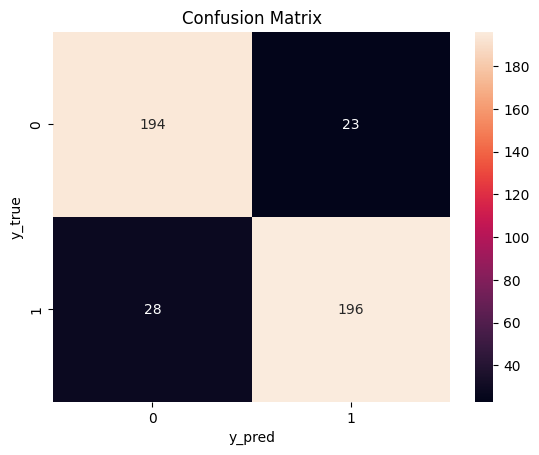


epoch: 1
----------
Train Loss: 25.685646 | Avg validation loss: 26.710703 | Validation accuracy: 90.929705 | Validation Recall 88.839286


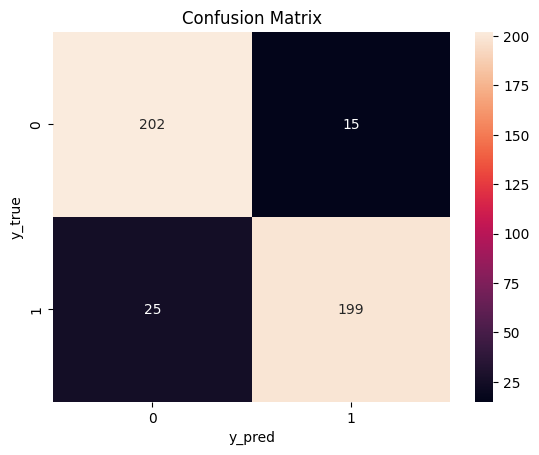


epoch: 2
----------
Train Loss: 15.654463 | Avg validation loss: 28.436211 | Validation accuracy: 88.662132 | Validation Recall 91.071429


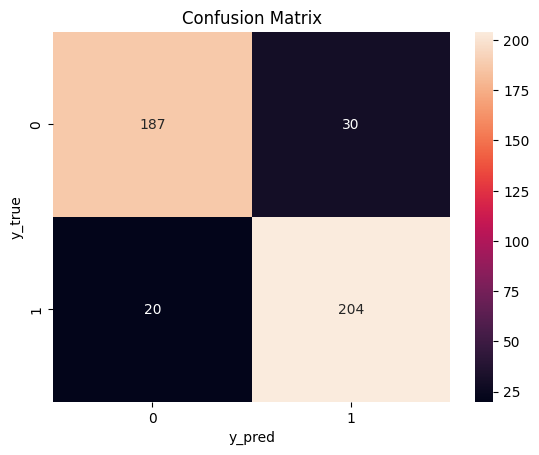


epoch: 3
----------
Train Loss: 9.320859 | Avg validation loss: 28.752180 | Validation accuracy: 88.888889 | Validation Recall 90.625000


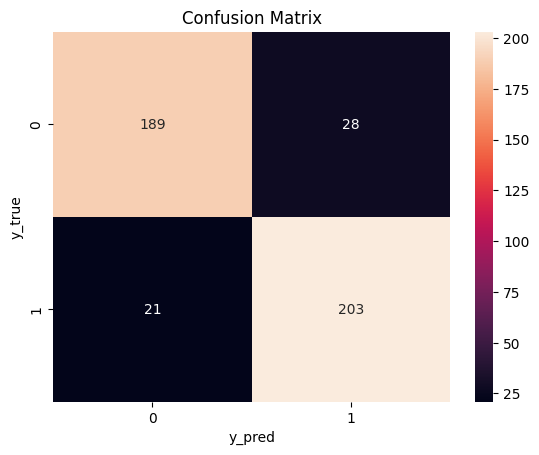

In [23]:
#for graphing purposes:
epoch_list = []
train_loss_list = []
avg_val_loss_list = []
val_accuracy_list = []
val_recall_list = []

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    print("-"*10)

    # train
    train_loss = train_step(model=model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler, device=device)
    # test
    avg_val_loss, val_accuracy, val_recall, cm = val_step(model=model, dataloader=validation_dataloader, optimizer=optimizer, scheduler=scheduler, device=device)
    # print stuffs
    print(f"Train Loss: {train_loss*100:.6f} | Avg validation loss: {avg_val_loss*100:.6f} | Validation accuracy: {val_accuracy*100:.6f} | Validation Recall {val_recall*100:.6f}")
    
    # log metrics to wandb
    # wandb.log({"Train Loss": train_loss, "Avg validation loss": avg_val_loss,
    #            "Validation accuracy":val_accuracy, "Validation Recall":val_recall,
    #            })

    sns.heatmap(cm, annot=True, fmt=".5g")
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.title('Confusion Matrix')
    plt.show()

    epoch_list.append(epoch)
    train_loss_list.append(train_loss)
    avg_val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(val_accuracy)
    val_recall_list.append(val_recall)

    print()
    
# wandb.finish()